This code implements the Gaussian zeroth-order and subgradient method to solve the offline semi-supervised clustering via minimisation of a submodular cost function.

Below the submodular cost is defined.

In [1115]:
import numpy as np
import numpy.linalg as la
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

# Data and kernel
X, true_labels = make_moons(n_samples=50, noise=0.04, random_state=7)
p = X.shape[0]
diff = X[:, np.newaxis, :] - X[np.newaxis, :, :]
dist_sq = np.sum(diff ** 2, axis=2)
K = np.exp(-dist_sq / (2 * 0.1))  # sigma^2 = 1

def mutual_information(A_bin, K):
    # if np.all(A_bin == 0) or np.all(A_bin == 1):
    #     return 0
    A_indices = np.where(A_bin == 1)[0]
    B_indices = np.where(A_bin == 0)[0]
    K_AA = K[np.ix_(A_indices, A_indices)] + 1e-8 * np.eye(len(A_indices))
    K_BB = K[np.ix_(B_indices, B_indices)] + 1e-8 * np.eye(len(B_indices))
    K_full = K + 1e-8 * np.eye(p)
    log_det_AA = la.slogdet(K_AA)[1]
    log_det_BB = la.slogdet(K_BB)[1]
    log_det_full = la.slogdet(K_full)[1]
    return  0.5*(log_det_AA + log_det_BB - log_det_full)

# Set up eta: unlabeled eta=0.5, labeled hard constraints
# np.random.seed(42)
labeled_cluster0 = np.random.choice(np.where(true_labels == 0)[0], 4, replace=False)  # 4 from moon 0 (exclude in A)
labeled_cluster1 = np.random.choice(np.where(true_labels == 1)[0], 4, replace=False)  # 4 from moon 1 (include from A)
labeled_indices = np.concatenate([labeled_cluster0, labeled_cluster1])
eta = np.full(p, 0.5)
eta[labeled_cluster1] = 1.0  # Must include
eta[labeled_cluster0] = 0.0  # Must exclude

def submodular_cost(A_bin, K, eta):
    I = mutual_information(A_bin, K)
    prior_term = 0.0
    for k in range(p):
        if A_bin[k] == 1:
            prior_term -= np.log(eta[k] + 1e-10)
        else:
            prior_term -= np.log(1 - eta[k] + 1e-10)
    return I + prior_term

# Evaluations
A_true_bin = (true_labels == 1).astype(int)
F_true = submodular_cost(A_true_bin, K, eta)

A_empty = np.zeros(p, dtype=int)
# A_empty[5]=1
F_empty = submodular_cost(A_empty, K, eta)

A_full = np.ones(p, dtype=int)
F_full = submodular_cost(A_full, K, eta)

A_random_bin = np.random.randint(0, 2, p)
F_random = submodular_cost(A_random_bin, K, eta)

A_one = np.zeros(p)
A_one[labeled_cluster1]=1
# A_one[6]=1
F_one = submodular_cost(A_one, K, eta)

A_zero = np.ones(p)
A_zero[labeled_cluster0]=0
F_zero = submodular_cost(A_zero, K, eta)

print(f"F at true: {F_true}")
print(f"F at empty: {F_empty}")
print(f"F at full: {F_full}")
print(f"F at random: {F_random}")
print(f"F at all zero but hard: {F_one}")
print(f"F at all one but hard: {F_zero}")

F at true: 31.103761421565544
F at empty: 121.21558529447947
F at full: 121.21558529447951
F at random: 207.0584899284795
F at all zero but hard: 42.768647357499155
F at all one but hard: 43.352563582563434


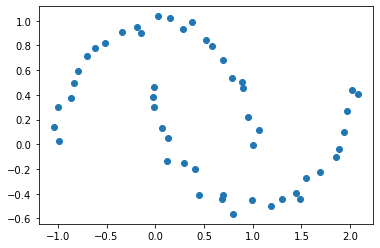

In [1116]:
plt.scatter(X[:,0],X[:,1])

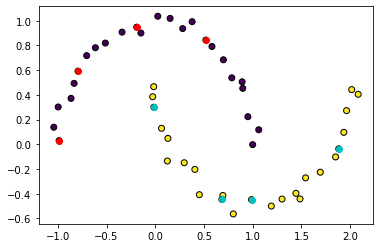

In [1117]:
plt.scatter(X[:,0], X[:,1], c=true_labels, edgecolors="k")
plt.plot(X[labeled_cluster0,0],X[labeled_cluster0,1],'or')
plt.plot(X[labeled_cluster1,0],X[labeled_cluster1,1],'oc')

Below the Lovasz Extension of the cost function is defined.

In [1118]:
# Polyhedron greedy algorithm
def polyhedrongreedy(F, V, w):
    n = len(V)
    w_sorted, I = np.sort(w)[::-1], np.argsort(w)[::-1]  # Sort in descending order
    x = np.zeros(n)
    A = np.array([], dtype=int)
    Fold = F(np.zeros(n, dtype=int))  # Initial empty set
    for i in range(n):
        Anew = np.concatenate((A, [V[I[i]]]))
        A_bin = np.zeros(n, dtype=int)
        A_bin[Anew] = 1
        x[I[i]] = F(A_bin) - Fold
        A = Anew
        Fold += x[I[i]]
    return x

# Lovász extension
def lovasz_extension(F, V, w):
    x = polyhedrongreedy(F, V, w)
    return np.dot(w, x) 

# Example usage
V = V = np.arange(p)  # Ground set
w0 = np.random.rand(p)
w0[labeled_cluster0] = 0
w0[labeled_cluster1] = 1
F = lambda A_bin: submodular_cost(A_bin, K, eta)

lovasz_val = lovasz_extension(F, V, w0)
print(f"Lovász extension value at w: {lovasz_val}")

# Optional: Evaluate at uniform weights for comparison
w_uniform = np.ones(p) / p
lovasz_val_uniform = lovasz_extension(F, V, w_uniform)
print(f"Lovász extension value at uniform weights: {lovasz_val_uniform}")

lovasz_val_true = lovasz_extension(F, V, A_true_bin)
print(f"Lovász extension value at true weights: {lovasz_val_true}")

lovasz_val_one = lovasz_extension(F, V, A_one)
print(f"Lovász extension value at all zero but hard: {lovasz_val_one}")

lovasz_val_zero = lovasz_extension(F, V, A_zero)
print(f"Lovász extension value at all one but hard: {lovasz_val_zero}")

Lovász extension value at w: -60.07286606069336
Lovász extension value at uniform weights: 5.759281940243e-16
Lovász extension value at true weights: -90.11182387291393
Lovász extension value at all zero but hard: -78.4469379369803
Lovász extension value at all one but hard: -77.86302171191603


Below the subgradient of the Lovasz extension is defined.

In [1119]:
def lovasz_subgradient(F, V, w):
    """
    Computes a subgradient of the Lovász extension of a submodular function F at point w.
    Args:
        F: Submodular set function, takes binary vector.
        V: Ground set indices (e.g., np.arange(p)).
        w: Point at which to compute subgradient (vector of size p).
    Returns:
        subgrad: Subgradient vector (size p).
    """
    n = len(V)
    w_sorted, I = np.sort(w)[::-1], np.argsort(w)[::-1]  # Sort in descending order
    subgrad = np.zeros(n)
    A = np.array([], dtype=int)
    Fold = F(np.zeros(n, dtype=int))  # Initial empty set
    for i in range(n):
        Anew = np.concatenate((A, [V[I[i]]]))
        A_bin = np.zeros(n, dtype=int)
        A_bin[Anew] = 1
        subgrad[I[i]] = F(A_bin) - Fold
        A = Anew
        Fold += subgrad[I[i]]
    return subgrad


FL = lambda w: lovasz_extension(F, V, w)
FL_subgrad = lambda w: lovasz_subgradient(F, V, w)

Below the ZO solver and subgradient solver are defined.

In [1120]:
def proj01(x,low=0,high=1):
    x = np.clip(x, low, high)
    return x


def grad(func, x, mu=0.05, Y=10):
    gs = []
    for _ in range(Y):
        u = np.random.normal(0, 1, size=len(x))
        g = (func(x + mu * u) - func(x)) / mu
        gs.append(g * u)
        g = np.mean(gs, axis=0)
        g[labeled_indices] = 0
    return g


def step(func, x, h, mu=0.05, Y=10):
    grd = grad(func, x, mu, Y)
    xx = x - h * grd
    return xx

def RM(func, x0, N, h=0.001, mu=0.05, proj=None, Y=10):
    dim1 = len(x0)
    x = np.zeros((dim1, N + 1))
    x[:, 0] = x0.ravel()
    for k in range(N):
        x[:, k + 1] = proj(step(func, x[:, k], h, mu, Y))
    return x


def submin(subfunc, x0, N, h=0.001, proj=None):
    dim1 = len(x0)
    x = np.zeros((dim1, N + 1))
    x[:, 0] = x0.ravel()
    for k in range(N):
        x[:, k + 1] = proj(x[:,k]-h*subfunc(x[:,k]))
    return x

The below function revcover the discrete set from the continuous variable.

In [1121]:
def round_solution(w, F):
    order = np.argsort(-w)  # sort in descending order
    best_set = None
    best_val = float("inf")
    A_bin = np.zeros(len(w), dtype=int)
    for k in range(1, len(w)+1):
        A_bin[:] = 0
        A_bin[order[:k]] = 1
        val = F(A_bin)
        if val < best_val:
            best_val = val
            best_set = A_bin.copy()
    return best_set, best_val


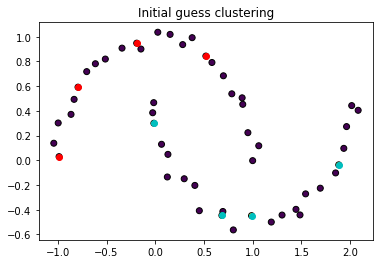

In [1122]:
A_0, F_0 = round_solution(w0, F)
plt.scatter(X[:,0], X[:,1], c=A_0, edgecolors="k")
plt.plot(X[labeled_cluster0,0],X[labeled_cluster0,1],'or')
plt.plot(X[labeled_cluster1,0],X[labeled_cluster1,1],'oc')
plt.title("Initial guess clustering")
plt.show()

Below we run the ZO solver and subgradient method to solve the minimisation problem. We plot the results to compare the methods.

In [1137]:
N = 4000
mu = 1e-5
h=2e-4
ww= RM(FL,w0,N,h=h,mu=mu,proj=proj01, Y=5)

In [ ]:
FLs = []
for i in range(N):
    FLs.append(FL(ww[:, i]))
# Find minimum value and corresponding ww[:,i]
min_idx = np.argmin(FLs)
min_val = FLs[min_idx]
min_vec = ww[:, min_idx]


Minimum FLs value: -87.85907101371613
Final FLs value: -87.51130251573687


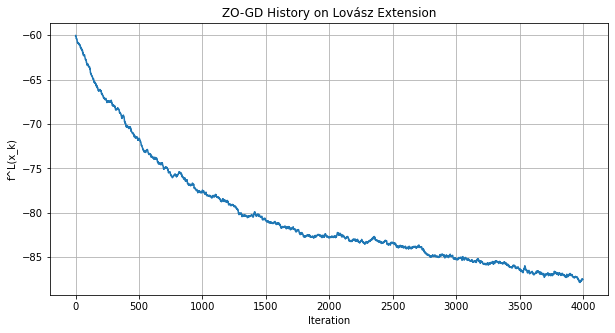

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(FLs)
plt.title('ZO-GD History on Lovász Extension')
plt.xlabel('Iteration')
plt.ylabel('f^L(x_k)')
plt.grid(True)
plt.savefig('fval.pdf', format='pdf',bbox_inches='tight')
print('Minimum FLs value:', min_val)
# print('Corresponding ww[:,i]:', min_vec)
print('Final FLs value:', FLs[-1])


Recovered cost: 31.103761421565544
Recovered labels: [0 0 0 1 1 1 0 0 0 1 1 1 1 0 0 1 1 1 0 0 1 0 0 1 1 0 0 0 1 0 1 1 0 0 0 1 1
 1 1 0 1 0 1 1 0 0 0 1 0 1]
thesh0.5 [0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1.
 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1.
 0. 1.]
thesh0.5 value 31.103761421565544
true 31.103761421565544


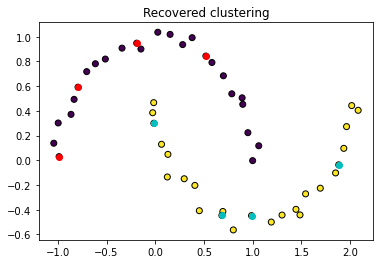

In [1139]:
# Final solution
w_final = min_vec
www = np.zeros(p)
www[np.where(w_final>=0.5)]=1
# Round back to a discrete cluster set
A_bin, F_val = round_solution(w_final, F)

print("Recovered cost:", F_val)
print("Recovered labels:", A_bin)
print("thesh0.5",www)
print("thesh0.5 value",F(www))
print("true", F(true_labels))

plt.scatter(X[:,0], X[:,1], c=A_bin, edgecolors="k")
plt.plot(X[labeled_cluster0,0],X[labeled_cluster0,1],'or')
plt.plot(X[labeled_cluster1,0],X[labeled_cluster1,1],'oc')
plt.title("Recovered clustering")
plt.show()

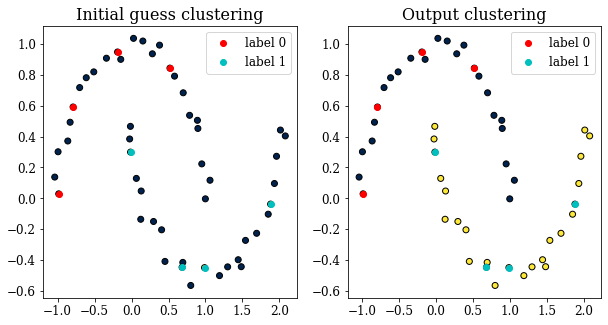

In [1212]:
font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 16}
font1 = {'family': 'serif', 'size': 12}
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.xticks(fontname='serif', fontsize=12, color='black')
plt.yticks(fontname='serif', fontsize=12, color='black')
plt.scatter(X[:,0], X[:,1], c=A_0, cmap='cividis', edgecolors="k")
plt.plot(X[labeled_cluster0,0],X[labeled_cluster0,1],'or', label='label 0')
plt.plot(X[labeled_cluster1,0],X[labeled_cluster1,1],'oc',label='label 1')
plt.title("Initial guess clustering",fontdict=font)
plt.legend(loc='best', prop=font1)
plt.subplot(1,2,2)
plt.xticks(fontname='serif', fontsize=12, color='black')
plt.yticks(fontname='serif', fontsize=12, color='black')
plt.scatter(X[:,0], X[:,1], c=A_bin, cmap='cividis', edgecolors="k")
plt.plot(X[labeled_cluster0,0],X[labeled_cluster0,1],'or',label='label 0')
plt.plot(X[labeled_cluster1,0],X[labeled_cluster1,1],'oc',label='label 1')
plt.title("Output clustering",fontdict=font)
plt.legend(loc='best', prop=font1)
plt.savefig('cluster.pdf', format='pdf',bbox_inches='tight')

In [1140]:
# print(labeled_cluster0,labeled_cluster1,labeled_indices)
print(np.sum(np.abs(true_labels-www)))
print(np.sum(np.abs(true_labels-A_bin)))
print(np.sum(np.abs(true_labels-A_0)))


0.0
0
21


In [1141]:
NN=N
wwsub = submin(FL_subgrad,w0,NN,h=h,proj=proj01)

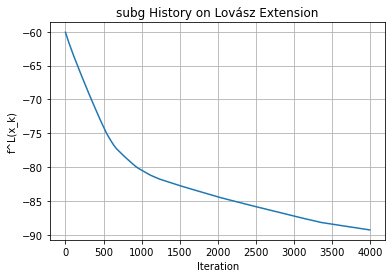

Minimum FLs value: -89.26990961023976
Final FLs value: -89.26990961023976


In [1142]:
FLsub = []
for i in range(NN):
    FLsub.append(FL(wwsub[:, i]))
# Find minimum value and corresponding ww[:,i]
min_idxs = np.argmin(FLsub)
min_vals = FLsub[min_idxs]
min_vecs = wwsub[:, min_idxs]
# Plot
plt.plot(FLsub)
plt.title('subg History on Lovász Extension')
plt.xlabel('Iteration')
plt.ylabel('f^L(x_k)')
plt.grid(True)
plt.show()
print('Minimum FLs value:', min_vals)
# print('Corresponding ww[:,i]:', min_vec)
print('Final FLs value:', FLsub[-1])

Recovered cost: 31.103761421565544
Recovered labels: [0 0 0 1 1 1 0 0 0 1 1 1 1 0 0 1 1 1 0 0 1 0 0 1 1 0 0 0 1 0 1 1 0 0 0 1 1
 1 1 0 1 0 1 1 0 0 0 1 0 1]
thesh0.5 [0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1.
 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1.
 0. 1.]
thesh0.5 value 31.103761421565544
true 31.103761421565544


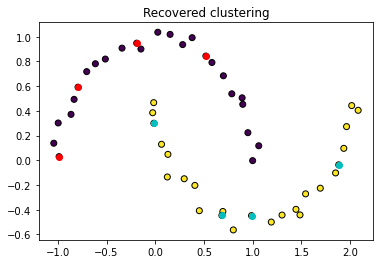

In [1143]:
# Final solution
ws_final = min_vec
wwws = np.zeros(p)
wwws[np.where(ws_final>=0.5)]=1
# Round back to a discrete cluster set
A_bins, F_vals = round_solution(ws_final, F)

print("Recovered cost:", F_vals)
print("Recovered labels:", A_bins)
print("thesh0.5",wwws)
print("thesh0.5 value",F(wwws))
print("true", F(true_labels))

plt.scatter(X[:,0], X[:,1], c=A_bins, edgecolors="k")
plt.plot(X[labeled_cluster0,0],X[labeled_cluster0,1],'or')
plt.plot(X[labeled_cluster1,0],X[labeled_cluster1,1],'oc')
plt.title("Recovered clustering")
plt.show()

In [1144]:
print(np.sum(np.abs(true_labels-wwws)))
print(np.sum(np.abs(true_labels-A_bins)))
print(np.sum(np.abs(true_labels-A_0)))

0.0
0
21


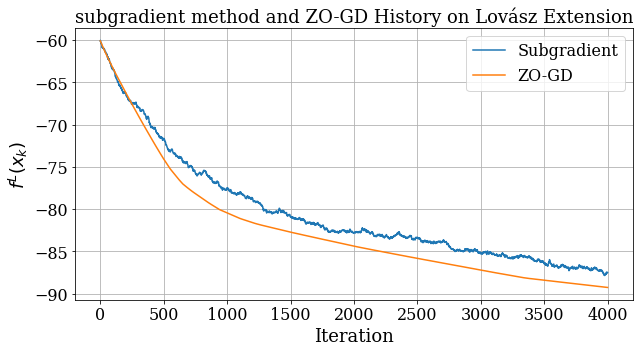

In [1209]:
font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 18}
font1 = {'family': 'serif', 'size': 16}
plt.figure(figsize=(10,5))
plt.xticks(fontname='serif', fontsize=16, color='black')
plt.yticks(fontname='serif', fontsize=16, color='black')
plt.plot(FLs,label='Subgradient')
plt.plot(FLsub,label='ZO-GD')
plt.title('subgradient method and ZO-GD History on Lovász Extension',fontdict=font)
plt.xlabel('Iteration',fontdict=font)
plt.ylabel(r'$f^L(x_k)$',fontdict=font)
plt.grid(True)
plt.legend(loc='best', prop=font1)
plt.savefig('fval2.pdf', format='pdf',bbox_inches='tight')

Below we implement the above solvers but with noisy function evaluations.

In [1156]:
F_noise = lambda A_bin: submodular_cost(A_bin, K, eta) + np.random.normal(0, 0.1)  # Adding Gaussian noise
FL_noise = lambda w: lovasz_extension(F_noise, V, w)
FL_subgrad_noise = lambda w: lovasz_subgradient(F_noise, V, w)

N = 4000
mu = 1e-2
h=1e-4
ww_noise= RM(FL_noise,w0,N,h=h,mu=mu,proj=proj01, Y=5)
wwsub_noise = submin(FL_subgrad_noise,w0,N,h=h,proj=proj01)

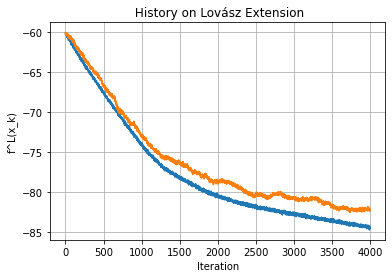

In [ ]:
FLs_noise=[]
FLsub_noise = []
for i in range(N):
    FLsub_noise.append(FL_noise(wwsub_noise[:, i]))
    FLs_noise.append(FL_noise(ww_noise[:, i]))
# Find minimum value and corresponding ww[:,i]
min_idx_noise = np.argmin(FLs_noise)
min_val_noise = FLsub[min_idx_noise]
min_vec_noise = wwsub[:, min_idx_noise]

min_idxs_noise = np.argmin(FLsub_noise)
min_vals_noise = FLsub[min_idxs_noise]
min_vecs_noise = wwsub[:, min_idxs_noise]
# Plot


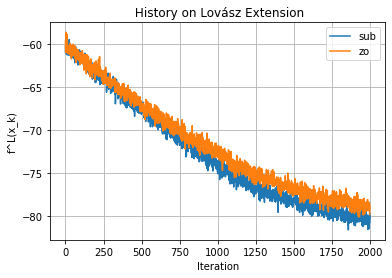

In [1194]:
plt.plot(FLsub_noise,label='sub')
plt.plot(FLs_noise,label='zo')
plt.title(' History on Lovász Extension')
plt.xlabel('Iteration')
plt.ylabel('f^L(x_k)')
plt.legend()
plt.grid(True)

Text(0.5, 1.0, 'Recovered clustering')

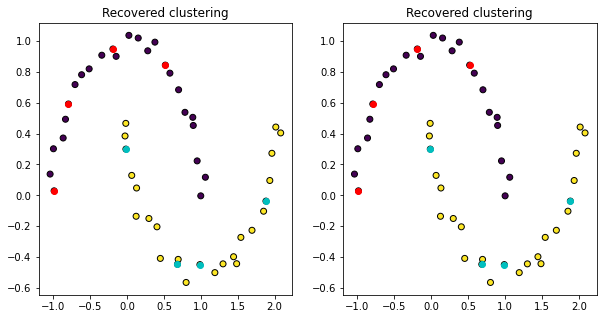

In [1162]:
# Final solution
w_noise_final = min_vec_noise
A_bin_noise, F_val_noise = round_solution(w_noise_final, F)
ws_noise_final = min_vecs_noise
As_bin_noise, F_vals_noise = round_solution(ws_noise_final, F)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X[:,0], X[:,1], c=A_bin_noise, edgecolors="k")
plt.plot(X[labeled_cluster0,0],X[labeled_cluster0,1],'or')
plt.plot(X[labeled_cluster1,0],X[labeled_cluster1,1],'oc')
plt.title("Recovered clustering")
plt.subplot(1, 2, 2)
plt.scatter(X[:,0], X[:,1], c=As_bin_noise, edgecolors="k")
plt.plot(X[labeled_cluster0,0],X[labeled_cluster0,1],'or')
plt.plot(X[labeled_cluster1,0],X[labeled_cluster1,1],'oc')
plt.title("Recovered clustering")

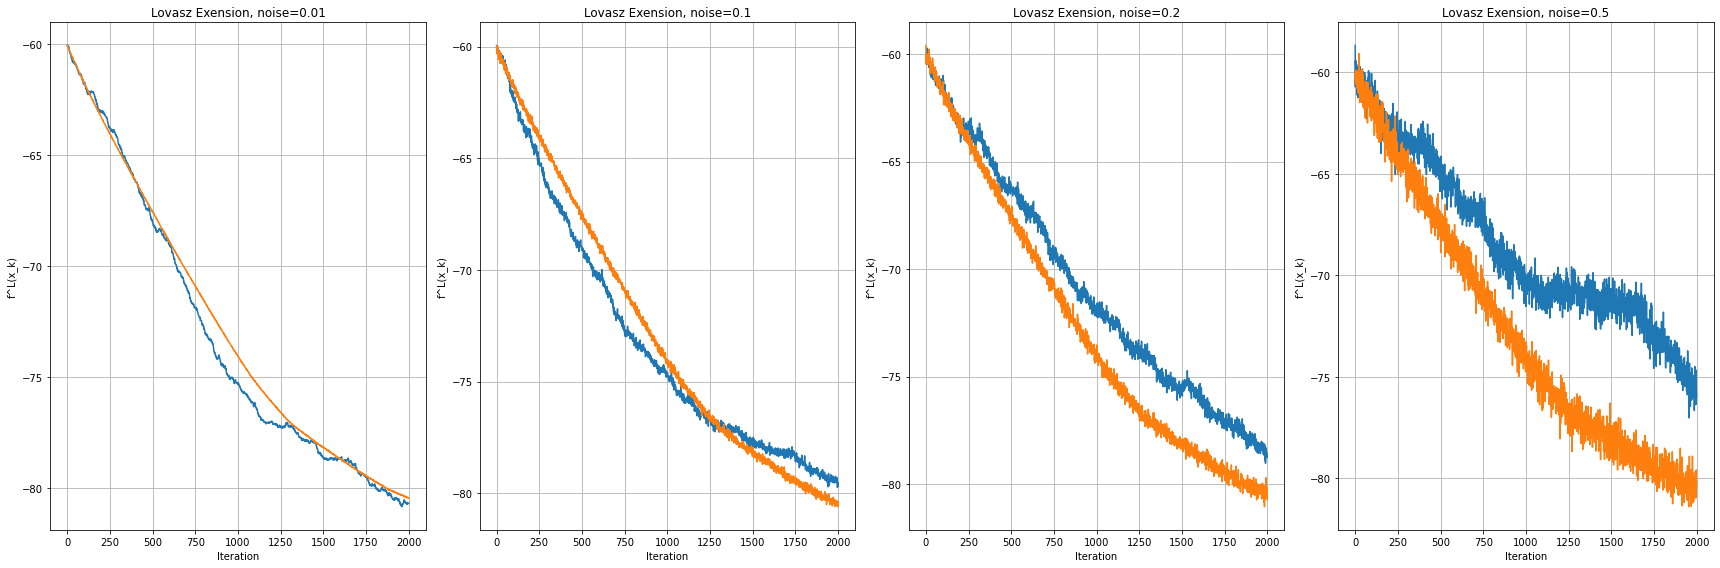

In [ ]:
# Repeat noisy experiments with different noise scales and plot histories
noise_scales = [0.01, 0.1, 0.2, 0.5]
N = 2000
mu = 1e-2
h = 1e-4
results = []
plt.figure(figsize=(24, 8))
for idx, scale in enumerate(noise_scales):
    F_noise = lambda A_bin: submodular_cost(A_bin, K, eta) + np.random.normal(0, scale)
    FL_noise = lambda w: lovasz_extension(F_noise, V, w)
    FL_subgrad_noise = lambda w: lovasz_subgradient(F_noise, V, w)
    ww_noise = RM(FL_noise, w0, N, h=h, mu=mu, proj=proj01, Y=5)
    wwsub_noise = submin(FL_subgrad_noise, w0, N, h=h, proj=proj01)
    FLs_noise = [FL_noise(ww_noise[:, i]) for i in range(N)]
    FLsub_noise = [FL_noise(wwsub_noise[:, i]) for i in range(N)]
    plt.subplot(1, len(noise_scales), idx + 1)
    plt.plot(FLs_noise, label=f'ZO-GD, scale={scale}')
    plt.plot(FLsub_noise, label=f'Subgrad, scale={scale}')
    plt.title(f'Lovasz Exension, noise={scale}')
    plt.xlabel('Iteration')
    plt.ylabel('f^L(x_k)')
    plt.legend('on')
    plt.grid(True)
plt.tight_layout()
plt.show()

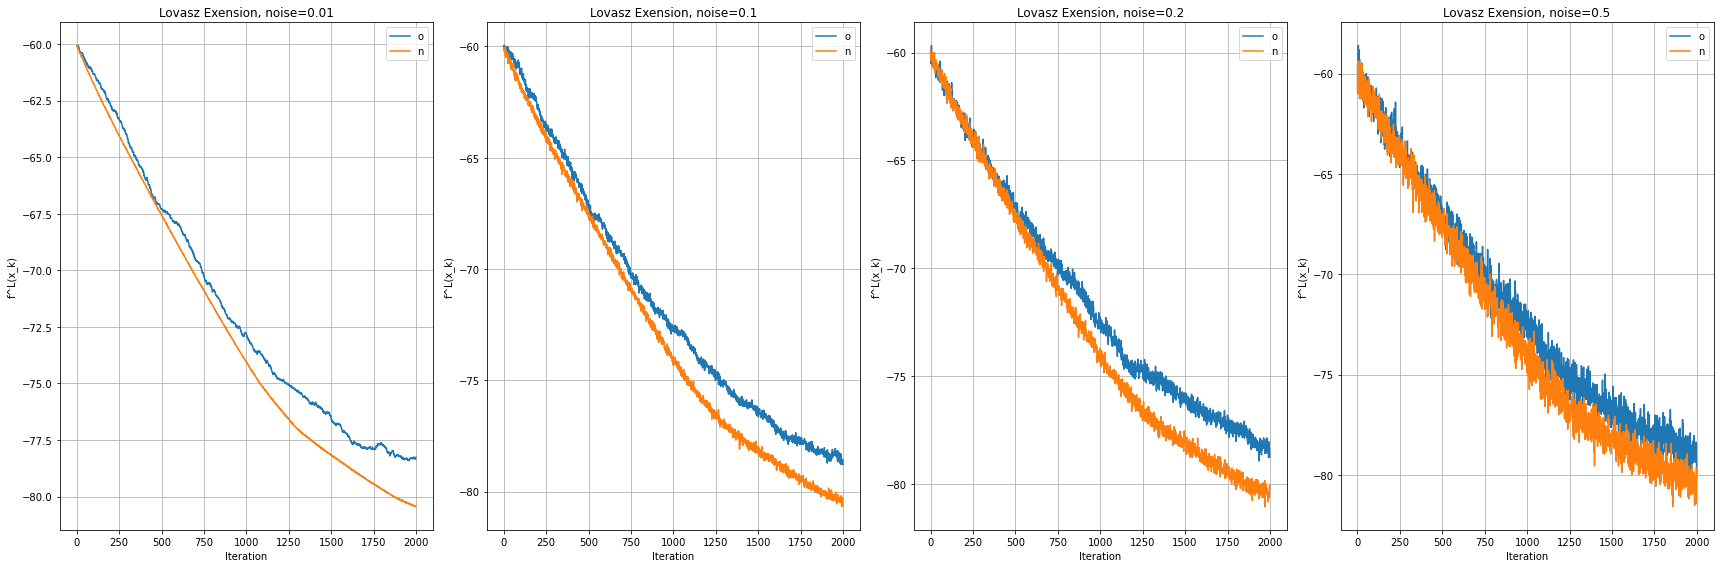

In [1170]:
# Repeat noisy experiments with different noise scales and plot histories
noise_scales = [0.01, 0.1, 0.2, 0.5]
N = 2000
mu = 1e-1
h = 1e-4
results = []
plt.figure(figsize=(24, 8))
for idx, scale in enumerate(noise_scales):
    F_noise = lambda A_bin: submodular_cost(A_bin, K, eta) + np.random.normal(0, scale)
    FL_noise = lambda w: lovasz_extension(F_noise, V, w)
    FL_subgrad_noise = lambda w: lovasz_subgradient(F_noise, V, w)
    ww_noise = RM(FL_noise, w0, N, h=h, mu=mu, proj=proj01, Y=10)
    wwsub_noise = submin(FL_subgrad_noise, w0, N, h=h, proj=proj01)
    FLs_noise = [FL_noise(ww_noise[:, i]) for i in range(N)]
    FLsub_noise = [FL_noise(wwsub_noise[:, i]) for i in range(N)]
    plt.subplot(1, len(noise_scales), idx + 1)
    plt.plot(FLs_noise, label=f'ZO-GD, scale={scale}')
    plt.plot(FLsub_noise, label=f'Subgrad, scale={scale}')
    plt.title(f'Lovasz Exension, noise={scale}')
    plt.xlabel('Iteration')
    plt.ylabel('f^L(x_k)')
    plt.legend('on')
    plt.grid(True)
plt.tight_layout()
plt.show()